In [89]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from sklearn.preprocessing import MinMaxScaler, RobustScaler 
# sklearn 의존성 문제 때문에 numpy 코드로 바꿔야 하나, 회사 가면 누가 이미 만들어 놨을 거다..

import FinanceDataReader as fdr

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["figure.figsize"] = (12, 6)

In [90]:
stock = fdr.DataReader("005930")
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2013-03-18,29200,29200,28680,28900,528791,NaN
2013-03-19,29000,29839,28960,29500,279542,0.020761
2013-03-20,29200,29700,29120,29200,270315,-0.010169
2013-03-21,29220,29480,29119,29140,235371,-0.002055
2013-03-22,29160,29360,29040,29100,213742,-0.001373


## 데이터 셋

In [91]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, csv_file="data/SBUX.csv", seq_length=10, train_ratio=0.8, is_train=True):
        self.seq_length = seq_length
        self.is_train = is_train

        df = df.copy()
        df["Date"] = df.index
        df["Date"] = pd.to_datetime(df["Date"])
        df = self._add_techinical_indicators(df)
        
        # 앙상블 모델을 써서 필요 없는 지표는 뺄 수 있다. 
        # 자료의 특성을 모를 때는 일단 다 집어 넣음
        features_cols = ["Close", "Volume", "MA_5", "MA_20",
                         "RSI", "Volatility", "Price_Change", "Volume_MA"]
        
        data = df[features_cols].values # df의 values는 판다스의 특징을 다 없애 버림. 
        # 스케일러를 돌리려면 결측치가 있으면 안됨. 따라서 결측치 처리를 함. 
        # 다만, 결측치를 어떻게 결정할지(넣을지, 뺄지, 어떤 값을 넣을지)는 모든 경우의 수를 다 돌려봄

        # 결측값 처리
        data_df = pd.DataFrame(data)
        data = data_df.ffill().bfill().values
        
        # if문 사용해서 다양한 스케일러를 써봐야 성능평가가 안정적으로 나옴
        self.scaler = RobustScaler()
        scaled_data = self.scaler.fit_transform(data)

        X, y = self._create_sequences(scaled_data, seq_length)

        train_size = int(len(X) * train_ratio)

        ## y값을 만드는 부분 (넘파이 배열로 바꾸고 토치로 바꾸는 것.) 넘파이 배열로 못 만들면 못함.
        if self.is_train:
            self.X = torch.FloatTensor(X[:train_size])
            self.y = torch.FloatTensor(y[:train_size])
            self.dates = df['Date'].iloc[seq_length : train_size + seq_length]
        else:
            self.X = torch.FloatTensor(X[train_size:])
            self.y = torch.FloatTensor(y[train_size:])
            self.dates = df['Date'].iloc[train_size + seq_length :]

    def _create_sequences(self, data, seq_length):
        xs, ys = [], []
        for i in range(len(data) - seq_length):
            x = data[i:i + seq_length]
            y = data[i + seq_length, 0] # 첫번째 컬럼을 선택/ 0이 빠지면 말이 안되며, 뺄 경우 8개의 컬럼을 다 예측하려 하는 것임
            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)
    
    def _add_techinical_indicators(self, df):
        # 이동평균
        df["MA_5"] = df["Close"].rolling(window=5).mean()
        df["MA_20"] = df["Close"].rolling(window=20).mean()

        # RSI
        delta = df["Close"].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df["RSI"] = 100 - (100 / (1 + rs))

        # 변동성
        df["Volatility"] = df["Close"].rolling(window=14).std()

        # 가격 변화율
        df["Price_Change"] = df["Close"].pct_change()

        # 거래량 이동평균
        df["Volume_MA"] = df["Volume"].rolling(window=10).mean()

        return df
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [92]:
seq_length = 10 # 10일 기준으로 볼거냐
batch_size = 60 # 몇 개의 데이터를 한번에 넣을거냐

train_dataset = TimeSeriesDataset(df=stock, seq_length=seq_length, is_train=True)
test_dataset = TimeSeriesDataset(df=stock, seq_length=seq_length, is_train=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 학습모델

### LSTM

In [93]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return self.fc(h_n.squeeze(0))

## 모델 학습

In [94]:
# 모델 돌릴 때 마다 이렇게 숫자를 바꿔야 하는 하드코딩 하면 안됨
# 매개변수를 지정해서 받아 오게끔 짜야함. # 즉 밖으로 빼라.
input_size = 8
hidden_size = 150
output_size = 1
num_epochs = 100
learning_rate = 0.001
num_layers_bilstm = 2

In [ ]:
lstm_model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)
# optimizer = 최적화 함수 == 로스를 줄이는 것 == 무엇으로? 아담형님으로

# 스케줄러 - 자연어 처리를 할때는 학습률을 줄여야함. 
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=10)
# 검증 손실이 줄어들지 않을 때, 학습률을 줄임 -> mode="min"
# 얼마나 줄일거야? 50% -> factor=0.5
# 10번동안 줄였는데, 안줄면 멈춰! -> patience=10

# 1. 조기 종료 파라미터
patience = 20 # 같은 값이 몇번 나올 때까지 참을래? / 클수록 epoch 다 도는 것임
patience_counter_lstm = 0
best_val_loss_lstm = float("inf") # 초기 값은 무한대
best_model_state_dict_lstm = None

# 2. 학습 시작
for epoch in range(num_epochs):
    lstm_model.train()
    epoch_train_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = lstm_model(batch_X)
        loss = criterion(outputs, batch_y.unsqueeze(-1)) # 손실함수가 가장 중요
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() # 학습 데이터의 loss 값만 뽑아냄
    epoch_train_loss /= len(train_loader) # 학습 데이터의 loss값 평균

    if (epoch+1) % 10 == 0:
        print(f'LSTM Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


    ## 검증과정을 거치는 부분 ## 확인(최적인가?)
    lstm_model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader: ## 데이터가 2개라 test 로더 쓰는 거지, val_loader 써야함.
            outputs = lstm_model(batch_X)
            loss = criterion(outputs, batch_y.unsqueeze(-1))
            epoch_val_loss += loss.item()
            
    scheduler.step(epoch_val_loss)
        
    if (epoch+1) % 10 == 0:
        print(f'LSTM Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}')


    ## 조기종료된 학습 데이터를 저장    
    if epoch_val_loss < best_val_loss_lstm:
        best_val_loss_lstm = epoch_val_loss
        patience_counter_lstm = 0
        best_model_state_dict_lstm = copy.deepcopy(lstm_model.state_dict())
    else:
        patience_counter_lstm += 1
        if patience_counter_lstm >= patience:
            print(f'LSTM 조기종료 [{epoch+1}/{num_epochs}], Val Loss: {epoch_train_loss:.4f}')
            break # 파이썬의 break은 나와 가장 가까운 for문을 탈출함.
if best_model_state_dict_lstm:
    lstm_model.load_state_dict(best_model_state_dict_lstm)
else:
    print(f'LSTM 조기종료하지 못했음')
        
# 조기 종료된 학습 데이터를 반드시 불러와야 됨


# 평가
lstm_model.eval()
lstm_test_predictions = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = lstm_model(batch_X)
        lstm_test_predictions.append(outputs.cpu().numpy())

lstm_test_predictions = np.concatenate(lstm_test_predictions)

lsmt_dummy = np.zeros((lstm_test_predictions.shape[0], 8))
lsmt_dummy[:, 0] = lstm_test_predictions.flatten()
lstm_test_predictions_rescaled = train_dataset.scaler.inverse_transform(lsmt_dummy)[:, 0]

y_test_dummy = np.zeros((test_dataset.y.shape[0], 8))
y_test_dummy[:, 0] = test_dataset.y.cpu().numpy().flatten()
y_test_rescaled = train_dataset.scaler.inverse_transform(y_test_dummy)[:, 0] 

LSTM Epoch [10/100], Loss: 0.0006
LSTM Epoch [10/100], Train Loss: 0.0006
LSTM Epoch [20/100], Loss: 0.0007
LSTM Epoch [20/100], Train Loss: 0.0006
LSTM Epoch [30/100], Loss: 0.0004
LSTM Epoch [30/100], Train Loss: 0.0006
LSTM 조기종료 [39/100], Val Loss: 0.0005


## 평가 시각화

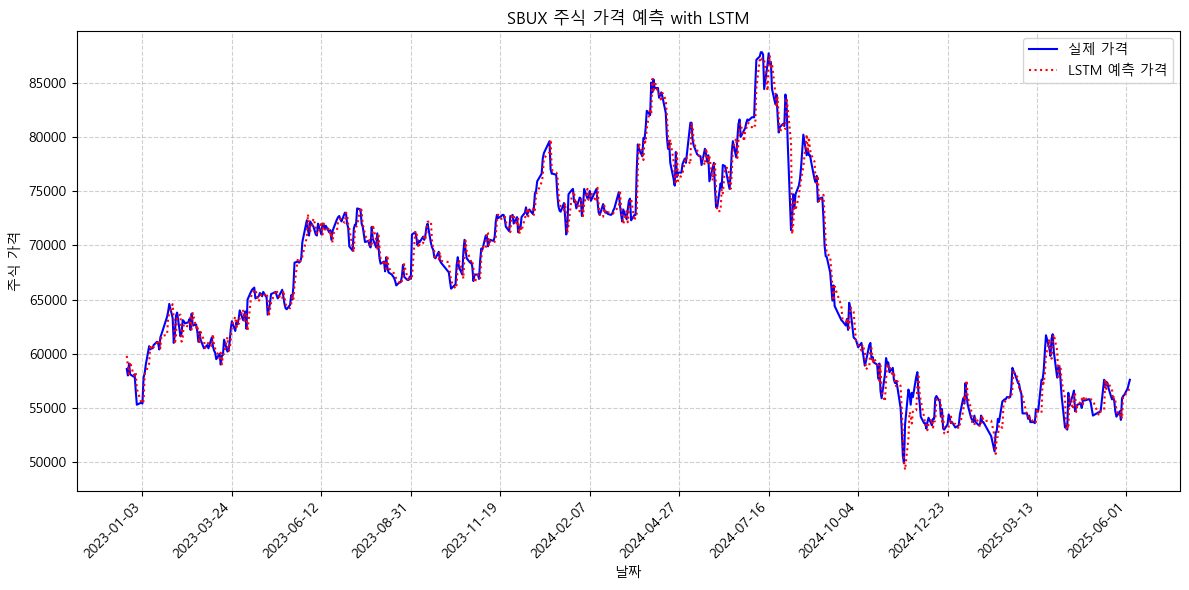

In [98]:
plt.plot(test_dataset.dates, y_test_rescaled, label='실제 가격', color='blue')
plt.plot(test_dataset.dates, lstm_test_predictions_rescaled, label='LSTM 예측 가격', color='red', linestyle=':')
plt.xlabel('날짜')
plt.ylabel('주식 가격')
plt.title('SBUX 주식 가격 예측 with LSTM')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=15))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [99]:
lstm_mse = np.mean((y_test_rescaled - lstm_test_predictions_rescaled)**2)
print(f'LSTM 모델 테스트 MSE (원래 스케일): {lstm_mse:.4f}')

LSTM 모델 테스트 MSE (원래 스케일): 1449580.8447
